In [28]:
import jax
import jax.numpy as jnp
import chex

from typing import NamedTuple

from experior.utils import PRNGSequence, moving_average
import matplotlib.pyplot as plt

jax.config.update("jax_debug_nans", True)

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## ISSUES
1. Diverging when optimizing both lambda and alpha
2. Estimating the expert distribution is not efficient (expert_mc_samples)
3. The value of beta is different between the generated samples and the likelihood estimation
4. How to show the derived prior makes sense? Is it close to the true prior in any sense? E.g., compared to the standard gaussian
5. Multi-armed bandit experiment

In [13]:
config = {
  "episodes": 1000,
  "n_trajectories": 1000,
  "num_envs": 500,
  "num_actions": 10
}

## Environments

In [47]:
from experior.envs import BayesStochasticBandit
from gymnax.environments import spaces

rng = PRNGSequence(42)
# multi-armed bandit environment
action_space = spaces.Discrete(config["num_actions"])
alpha_betas = jax.random.uniform(next(rng), shape=(config["num_experiments"], config["num_actions"], 2)) * 10. + 1.
prior_functions = jax.tree_util.Partial(lambda key: jax.random.beta(key, alpha_betas[i, :, 0], alpha_betas[i, :, 1]))
reward_dist_fn = jax.tree_util.Partial(lambda key, means, _, action: jax.random.bernoulli(key, means[action]))
best_action_value_fn = jax.tree_util.Partial(lambda means, _: (means.argmax(), means.max()))
# mutli_armed_bandits = ja[BayesStochasticBandit(action_space, prior_functions[i], reward_dist_fn, best_action_value_fn) for i in range(config["num_experiments"])]

TypeError: float() argument must be a string or a number, not 'Partial'

## Generate Expert Trajectories

In [22]:
from experior.experts.default_discrete_action import generate_optimal_trajectories
rng_keys = jax.random.split(next(rng), config["num_experiments"])
expert_trajectories = [generate_optimal_trajectories(rng_keys[i], mutli_armed_bandits[i], config["n_trajectories"], 1) for i in range(config["num_experiments"])]

In [44]:
expert_entropies = jnp.array([jax.vmap(lambda p: p * jnp.log(p+1))(jnp.bincount(expert_trajectories[i].action.flatten(), minlength=config["num_actions"]) / config["num_experiments"]).sum() for i in range(config["num_experiments"])])

In [45]:
expert_entropies

Array([11.01195  , 10.931009 , 11.295147 , 11.053233 , 10.954267 ,
       10.920246 , 10.589722 , 10.9191885, 10.592782 , 11.181662 ,
       11.113698 , 11.098416 , 11.038307 , 11.026683 , 10.839236 ,
       10.898    , 11.036129 , 10.967688 , 10.937531 , 11.20318  ,
       11.129661 , 10.834372 , 10.898675 , 11.138345 , 10.973424 ,
       11.233536 , 10.832342 , 11.46609  , 10.971723 , 11.078487 ,
       11.00817  , 11.394907 , 10.752537 , 10.961635 , 10.672072 ,
       11.184466 , 10.885111 , 10.906828 , 10.737137 , 10.926585 ,
       11.147759 , 10.747755 , 11.158501 , 10.987072 , 10.870419 ,
       11.327436 , 10.983594 , 11.340212 , 10.962785 , 10.997529 ,
       11.003739 , 10.858136 , 11.12132  , 10.876431 , 11.009317 ,
       10.984295 , 10.8040285, 11.043919 , 10.992959 , 10.963398 ,
       10.957334 , 11.047359 , 11.101507 , 11.082677 , 10.874    ,
       10.885117 , 11.068524 , 11.097288 , 10.741403 , 10.973286 ,
       11.07441  , 10.876752 , 11.301705 , 11.095125 , 10.8926

## Max Entropy Prior

In [5]:
expert_config = NoisyRationalExpertConfig(env_param=env_params, beta=config["EXPERT_BETA"], action_n_samples=config["EXPERT_MC_SAMPLES"])

max_entropy_conf = MaxEntropyPriorConfig(env=env,
                                         env_param=env_params,
                                         epsilon=config["MAX_ENT_EPSILON"],
                                         lr=config["MAX_ENT_LR"],
                                         max_grad_norm=config["MAX_GRAD_NORM"],
                                         mc_samples=config["MAX_ENT_PRIOR_MC_SAMPLES"],
                                         expert_config=expert_config,
                                         epochs=config["MAX_ENT_EPOCHS"],
                                         max_prior_param_value=None,
                                         lambda_=config["MAX_ENT_LAMBDA"])

max_entropy_prior_trainer, unnoramlized_log_prior = make_max_entropy_prior(max_entropy_conf)


In [6]:
max_entropy_prior_trainer = jax.jit(max_entropy_prior_trainer)
max_ent_out = max_entropy_prior_trainer(next(rng), expert_trajectory=expert_trajectories)


alpha min, max: 0.22131142 7.65719


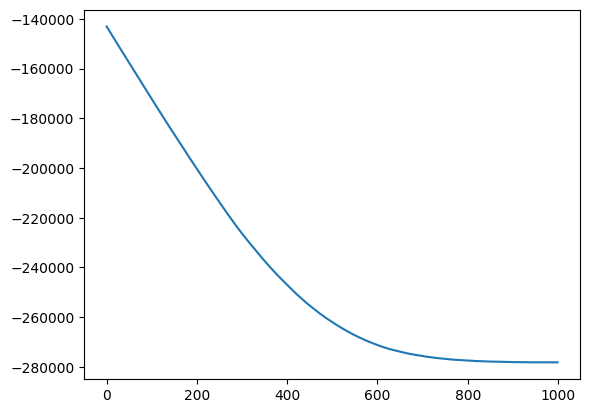

In [7]:
import matplotlib.pyplot as plt
plt.plot(max_ent_out["metrics"]["loss"])
log_alphas = max_ent_out["runner_state"][1]["log_alphas"]
print("alpha min, max:", log_alphas.min(), log_alphas.max())


In [8]:
K = 500
prior_log_fn = jax.tree_util.Partial(lambda k, p: unnoramlized_log_prior(prior_params=max_ent_out["prior_params"], expert_trajectory=expert_trajectories, rng=k, unobserved_context=p))
init_params = env_params.ref_prior_fn(next(rng), K)
rngs = jax.random.split(next(rng), K)
langevin_sampling = jax.jit(langevin_sampling, static_argnames=("step_size", "num_steps", "grad_opt"))
params = jax.vmap(langevin_sampling, in_axes=(0, 0, None, None, None, None))(rngs, init_params, prior_log_fn, config["LANGEVIN_PRIOR_STEP_SIZE"], config["LANGEVIN_PRIOR_NUM_STEPS"], jax.tree_util.Partial(lambda grad: jnp.clip(grad, -config["LANGEVIN_GRAD_CLIP"], config["LANGEVIN_GRAD_CLIP"])))


In [9]:
print("mean: ", params.mean(axis=0), "\nstd: ", params.std(axis=0))
approx_prior_fn = lambda k, p: jax.scipy.stats.norm.logpdf(p, loc=params.mean(axis=0), scale=params.std(axis=0)).sum(axis=-1)


mean:  [ 2.5161362e-01 -4.1193631e-01 -1.1125755e-03  1.3834493e-04
 -2.4826680e-03 -6.7046162e-04  1.8684051e-03  2.1220576e-03
  2.8421714e-03 -1.3813634e-04] 
std:  [4.5770335  4.545849   0.04618767 0.04403238 0.04509189 0.04961609
 0.04936257 0.04874934 0.05543748 0.04617571]


## Max-Entropy Posterior Sampling

In [22]:
from src.envs import Trajectory

def make_posterior_sampling(config):
    def langevin_posterior_sampling(rng, last_param, trajectory, ind, unnormal_log_prior):
      # using https://proceedings.mlr.press/v119/mazumdar20a/mazumdar20a.pdf
        def _update_parameters(runner_state, _):
            rng, param, trajectory = runner_state
            rng, rng_ = jax.random.split(rng)
            # Compute the gradient of the unnormalized log prior
            grad_log_prior = jax.grad(lambda k, p: unnormal_log_prior(k, p).sum(), argnums=(1))(rng_, param)

            rng, rng_ = jax.random.split(rng)
            contexts = trajectory.context
            actions = trajectory.action
            rewards = trajectory.reward
            # Compute the gradient of the log likelihood for a batch of transitions that is non nan
            batch_indices = jax.random.bernoulli(rng_, p=config["LANGEVIN_BATCH_RATIO"], shape=(contexts.shape[0],))
            step_size = config["LANGEVIN_STEP_SIZE"] /(ind.sum() + 1)  # TODO maybe better step size
            indices = jnp.logical_and(batch_indices, ind).reshape(-1, 1)
            reward_log_likelihood_fn = lambda p, c, r, a: -0.5 * (env_params.Q_function(p, c, a) - r) ** 2
            def log_likelihood_fn(p):
                log_like = jax.vmap(reward_log_likelihood_fn, in_axes=(None, 0, 0, 0))(p, contexts, rewards, actions)
                return (log_like * indices).sum()

            grad_log_likelihood = jax.grad(log_likelihood_fn)(param)
            # Sum the gradients to get the gradient of the log posterior
            grad_log_posterior = grad_log_prior + 1./config["LANGEVIN_BATCH_RATIO"] * grad_log_likelihood

            # write a clip the gradient
            grad_log_posterior = jnp.clip(grad_log_posterior, -config["LANGEVIN_GRAD_CLIP"], config["LANGEVIN_GRAD_CLIP"])


            # Langevin dynamics update rule
            rng, rng_ = jax.random.split(rng)
            noise = jax.random.normal(rng_, param.shape) * jnp.sqrt(2 * step_size)
            updated_param = param + step_size * grad_log_posterior + noise
            runner_state = (rng, updated_param, trajectory)
            return runner_state, None

        runner_state = (rng, last_param, trajectory)
        runner_state, _ = jax.lax.scan(_update_parameters, runner_state, None, config["LANGEVIN_NUM_STEPS"])
        return runner_state[1]

    def rollout(rng, log_prior_fn):
        # INIT ENV
        rng, _rng = jax.random.split(rng)
        reset_rng = jax.random.split(_rng, config["NUM_ENVS"])
        obsv, env_state = jax.vmap(env.reset, in_axes=(0, None))(reset_rng, env_params)

        rng, rng_ = jax.random.split(rng)
        init_param_rng = jax.random.split(rng_, config["NUM_ENVS"])
        init_params = jax.vmap(env_params.ref_prior_fn, in_axes=(0, None))(init_param_rng, 1)

        def _env_step(runner_state, i):
            env_state, rng, params, trajectories, time_steps = runner_state
            context = env_state.current_context

            # SELECT ACTION (Thompson Sampling)
            posterior_rng = jax.random.split(rng, config["NUM_ENVS"])
            indices = time_steps < i
            params = jax.vmap(langevin_posterior_sampling, in_axes=(0, 0, 0, None, None))(posterior_rng, params, trajectories, indices, log_prior_fn)
            action =  env_params.best_action_value_fn(params, env_state.current_context)[0]


            # STEP ENV
            rng, _rng = jax.random.split(rng)
            rng_step = jax.random.split(_rng, config["NUM_ENVS"])
            obsv, env_state, reward, done, info = jax.vmap(
                env.step, in_axes=(0, 0, 0, None)
            )(rng_step, env_state, action, env_params)

            actions = trajectories.action.at[:, i, :].set(action)
            contexts = trajectories.context.at[:, i, :].set(context)
            rewards = trajectories.reward.at[:, i, :].set(reward)
            trajectories = Trajectory(action=actions, context=contexts, reward=rewards)
            runner_state = (env_state, rng, params, trajectories, time_steps)
            return runner_state, None

        max_steps = env_params.max_episodes
        time_steps = jnp.arange(max_steps)
        trajectories = Trajectory(
            action=jnp.empty(
                (env_state.last_action.shape[0], max_steps, env_state.last_action.shape[-1])
            ),
            context=jnp.empty(
                (
                    env_state.current_context.shape[0],
                    max_steps,
                    env_state.current_context.shape[-1],
                )
            ),
            reward=jnp.empty(
                (env_state.last_reward.shape[0], max_steps, env_state.last_reward.shape[-1])
            ),
        )
        runner_state = (env_state, rng, init_params, trajectories, time_steps)
        runner_state, _ = jax.lax.scan(_env_step, runner_state, jnp.arange(max_steps))

        return {"runner_state": runner_state, "metrics": runner_state[3]}

    return rollout


In [23]:
psrl = make_posterior_sampling(config)
psrl_jit = jax.jit(psrl, static_argnums=(1,))
config["LANGEVIN_GRAD_CLIP"] = 20.

normal_log_prior_fn = lambda key, p: jax.scipy.stats.norm.logpdf(p).sum(axis=-1)

true_prior = lambda k, p: jax.scipy.stats.norm.logpdf(p, loc=jnp.zeros((1, 10)), scale=jnp.array([1., 1.] + [0. for i in range(8)]).reshape(1, -1)).sum(axis=-1)
# TODO fix this. The true prior is not a normal distribution but a uniform ball

cnfg.update("jax_disable_jit", False)

max_ent_out = psrl_jit(next(rng), approx_prior_fn)
normal_out = psrl_jit(next(rng), normal_log_prior_fn)
true_out = psrl_jit(next(rng), true_prior)


In [15]:
def moving_average(data, window_size):
    """Smooth data by calculating the moving average over a specified window size."""
    return jnp.convolve(data, jnp.ones(window_size)/window_size, mode='valid')


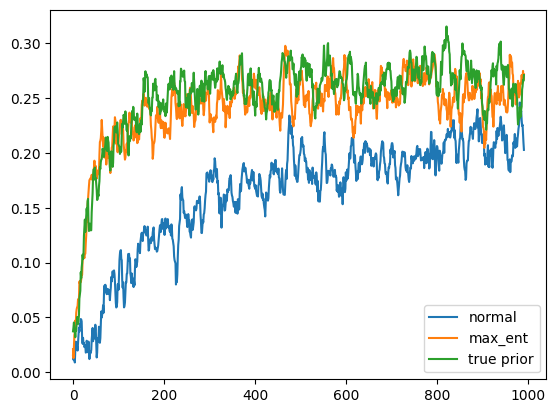

In [24]:
plt.plot(moving_average(normal_out["metrics"].reward.mean(axis=0).reshape(-1,), 10), label="normal")
plt.plot(moving_average(max_ent_out["metrics"].reward.mean(axis=0).reshape(-1,), 10), label="max_ent")
plt.plot(moving_average(true_out["metrics"].reward.mean(axis=0).reshape(-1,), 10), label="true prior")
plt.legend()
plt.show()
